<a href="https://colab.research.google.com/github/geoffwoollard/learn_cryoem_math/blob/master/nb/poisson_noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal
1. Explore Poisson statistics
  * forward models
  * show how Poisson statistics becomes Gaussian statistics in the limit of high electron count
2. Extend 2D Classification using the EM algorithm to Poisson noise in real space
3. Learn Poisson noise parameters

# Motivation
CryoEM data is reported to be Poisson. At large electron counts (e.g. $ < 100$), this can be approximated as Gaussian. However, at low electron counts , the Gaussian approiximation breaks down. The EM algorithm can be extended to Poisson statistics.

In Gaussian stats we taking the difference between the image and template and do a multiplicative correlation. In Poisson statistics there is something similar with the template to the power of the observed pixel values. Care must be taken to do this in log space, and exponentiate later for numerical stability.

# Resources

Snyder, D. L., White, R. L., & Hammoud, A. M. (1993). Image recovery from data acquired with a charge-coupled-device camera. Journal of the Optical Society of America A, 10(5), 1014. http://doi.org/10.1364/JOSAA.10.001014
  * Poisson statistics for CCD cameras, with CCD specific noise modeled with Poisson stats. Expectation-maximization algorithm. Application to / exemplified with astronomy (Hubble telescope), rather than electron microscopy.
  * Poisson noise model has a per pixel noise $\lambda$ parameter, but the same equation ties all of the pixel noise parameters together: $\mu(j) = \beta \sum_{i=0}^{I-1}p(j|i)\lambda(i)$; where $i$ is the index over the object and $j$ is the index over the detector. The paper explains how to get the $\lambda$s, which have dependence on the object.
  * The final detection is additive with Poisson and also gaussian. Equations are developed for the pure Poisson case and then extended when the gaussian is non zero by approximating the Gaussian as a Poisson.
  * The pixels are assumed to be independent, but the poisson parameter of each pixel has does depend on the object through its $\lambda (i)$ dependence. To estimate these some measurements of the detector in dark and uniform conditions are obtained empirically for that detector and then used.
  * There is a literature of a half dozen papers from the 70s-late 80s on the EM algorithm and Poisson noise, especially for (positron) emission tomography.

Vulović, M., Ravelli, R. B. G., van Vliet, L. J., Koster, A. J., Lazić, I., Lücken, U., … Rieger, B. (2013). Image formation modeling in cryo-electron microscopy. Journal of Structural Biology, 183(1), 19–32. http://doi.org/10.1016/j.jsb.2013.05.008
  * In depth discussion and simulation of forward model of electrons. The authors include employees at FEI, a major company that makes electron microscopes.

Zuo, J. M. (2000). Electron detection characteristics of a slow-scan CCD camera, imaging plates and film, and electron image restoration. Microscopy Research and Technique, 49(3), 245–268. http://doi.org/10.1002/(SICI)1097-0029(20000501)49:3<245::AID-JEMT4>3.0.CO;2-O
  * In depth discussion of CCD cameras. Discussion and simulation of Poisson noise

Peacock, J., & Cooke, D. (2017). Counting Statistics: The Significance of Errors, (47), 19. https://www.roe.ac.uk/japwww/teaching/astrostats/astrostats2012.pdf
  * derivation of Poisson to Gaussian distribution at large $\lambda$

Rickgauer, J. P., Grigorieff, N., & Denk, W. (2017). Single-protein detection in crowded molecular environments in cryo-EM images. ELife, 6, 1–22. http://doi.org/10.7554/eLife.25648
  * Comments on Poisson statistics, and simulation of data with forward model (using poisson stats?)

Zhao, Z., Liu, L. T., & Singer, A. (2020). Steerable ePCA: Rotationally Invariant Exponential Family PCA. IEEE Transactions on Image Processing, 29(3), 6069–6081. http://doi.org/10.1109/TIP.2020.2988139
  * Poisson stats for denoising on XFEL data and natural images of faces. Denoises individual images, using special PCA for non-gaussian data (not EM algorithm).




# Setup

In [ ]:
%%bash
wget ftp://ftp.ebi.ac.uk/pub/databases/emdb/structures/EMD-9243/map/emd_9243.map.gz
gunzip emd_9243.map.gz
rm mrcc.py twod.py
wget https://raw.githubusercontent.com/asarnow/pyem/master/pyem/mrc.py
wget https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/master/code/twod.py
pip install pyfftw

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mrc
from twod import *
from scipy.ndimage import rotate, zoom
import scipy

In [3]:
fname = 'emd_9243.map'#'/content/drive/My Drive/repos/learn_cryoem_math/data/ouhn_Data1_P1/emd_9243_downsample_64pix.mrc'#emd_9243_downsample_128pix_lp3A.mrc.mrc'#'emd_9243.map'
vol = mrc.read(fname)


4.106200580596944

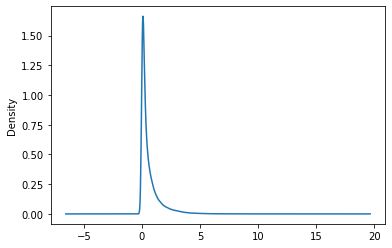

In [4]:
pd.Series(pd.Series(vol[vol>1e-3].flatten()).sample(10**5)).plot.kde()
np.percentile(vol[vol>1e-3].flatten(),99)

There is some streks along grid axes in the averaged 2D image. We can get rid of this by just keeping the strong values from the signal, and clipping the noise.

(0.16825481, 1.0)

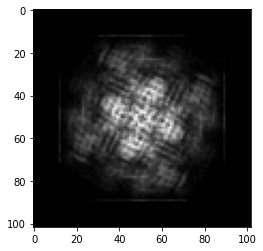

In [6]:
vol = mrc.read(fname)
cutoff = np.percentile(vol[vol>1e-5].flatten(),50) 
vol[vol<cutoff] = 0
A = vol.mean(2)
A=zoom(A,zoom=0.4) # zoom to down sample, numerical stability problems because too many pixels
A = np.pad(A,pad_width=A.shape[0]//7,mode='constant')
A = (A - A.min()) / (A.max()-A.min()) # divide by mean or std ?
nx, ny = A.shape
assert nx == ny
plt.imshow(A,cmap='gray')
A.std(), A.max()

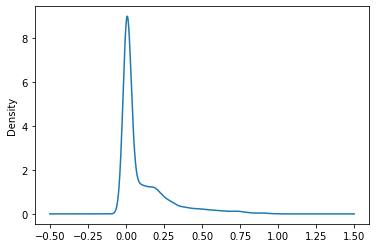

In [7]:
pd.Series(A.flatten()).plot.kde()

# Simulate data with Poisson Noise
We can simulate the data with poisson noise. The scaling factor simulates the electron dose. At low dose we get noisy images (which is what we'd typically use to preserve the fragile specimen).

## Additive Poisson noise to scaled signal
The poisson noise is an integer value, governed by the parameter $\lambda$, which is taken to be on the scale of $A$ (the mean of $A$, multipled by a constant), where c is some constant so that the image visually looks noisy.
$$X_{i \alpha} = cA_\alpha + N_{poisson}$$
$$P(N_{poisson} = k | \lambda) = \lambda^ke^{-\lambda}/k!$$

In [ ]:
scale=0.001
A_true_scaled = 1000*A
lam = 0.5#A_true_scaled.mean()*noise_scale
noise = np.random.poisson(lam=lam, size=A.size).reshape(A.shape)
x = scale*A_true_scaled + noise
do_2dplot(x)

In [ ]:
pd.Series(noise.flatten()).plot.hist()

In [ ]:
pd.Series(scale*A_true_scaled.flatten()).plot.hist()

In [ ]:
pd.Series(x.flatten()).plot.hist()

In [ ]:
pd.Series((x-scale*A_true_scaled).flatten()).plot.hist()

### Batch
* Check now many (aligned) examples are needed to get a crisp image. Is this realistic?
* include window so when rotate later no artefacts.

In [ ]:
scale=0.001
A_true_scaled = 1000*A
lam = 0.5

N=1000
X = np.zeros((N,)+A.shape)
for i in range(N):
  X[i] = scale*A_true_scaled + np.random.poisson(lam=lam, size=A.size).reshape(A.shape)

  
A_prev = X.mean(0)
do_2dplot(A_prev)

In [ ]:
do_2dplot(X[0])

In [ ]:
xminusA = X[0] - A_prev
#do_2dplot(xminusA)
pd.Series(xminusA.flatten()).plot.hist()
xminusA.mean()


In [ ]:
pd.Series(X[0].flatten()).plot.hist()


The noise is always a positive number, so we need to check that we are defining our observed images and true image in a way that gets rid of bias. Here we see the difference centred around a mean of zero, so we are OK.

## Poisson Noise and Signal with mean $\lambda=cA_\alpha + \lambda_k$
* each pixel has its own poisson parameter from the signal, plus iid poisson noise shared over all pixels. 

0 0 1 0
1 0 2 1
2 1 0 2
3 1 1 0
4 1 2 1
5 2 0 2
6 2 1 0
7 2 2 1
8 3 0 2
9 3 1 0


Text(0.5, 1.0, 'ground truth')

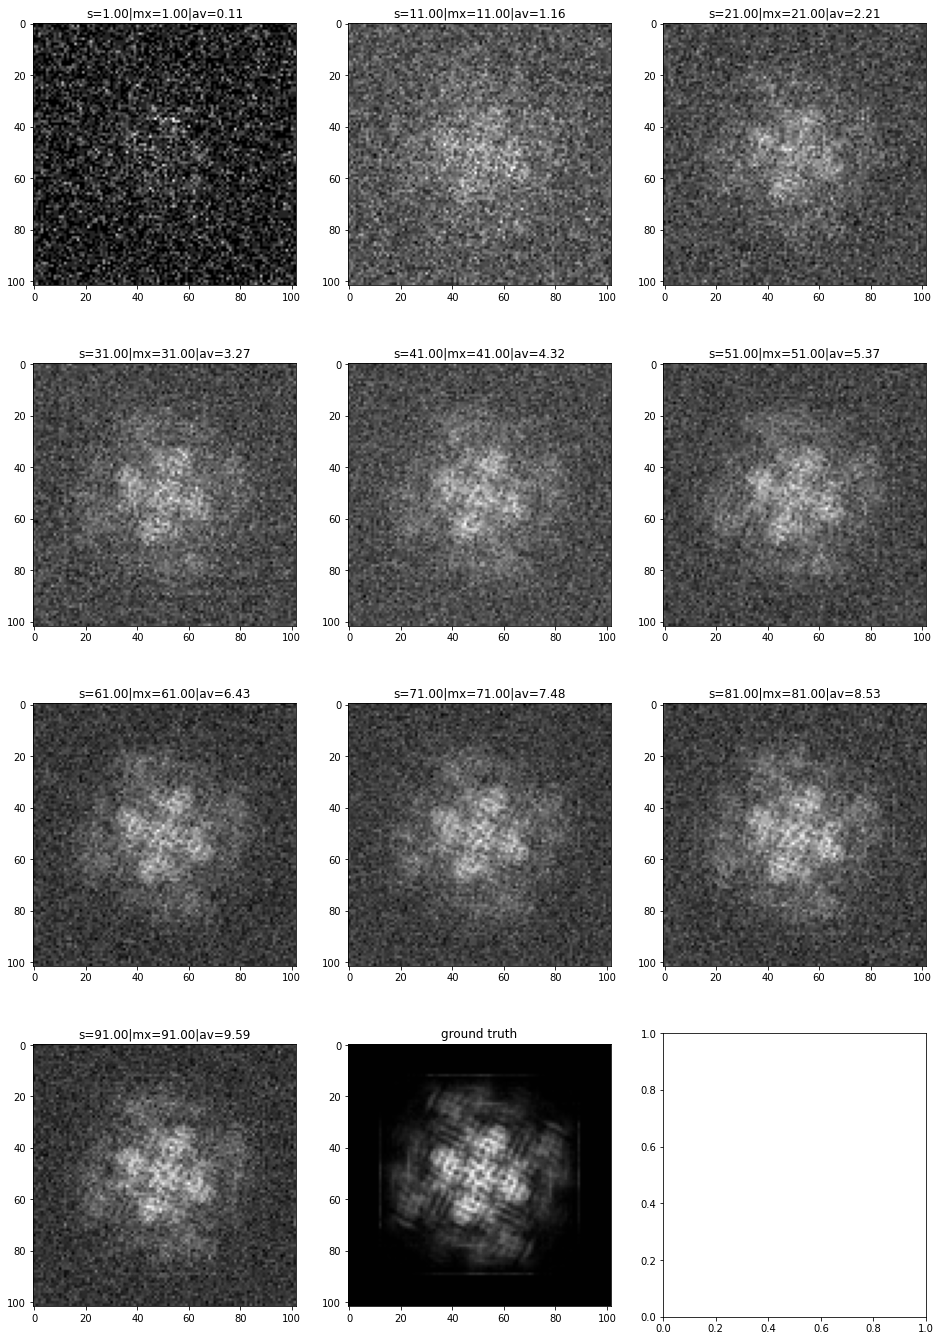

In [ ]:
scales = range(1,100,10)#[0.1,0.25,0.5,0.75] + list(range(1,10)) + [10,30,100]
fig, axes = plt.subplots(np.ceil((len(scales)+1)/3).astype(int),3, figsize=(16,24))
lam_k = 100
r=0
c=0
for i, scale in enumerate(scales):
  X = np.random.poisson(A*scale+scale)# + np.random.poisson(lam_k,size=A.size).reshape(A.shape)
  axes[r,c].imshow(X,cmap='gray') ; axes[r,c].set_title('s=%.2f|mx=%1.2f|av=%1.2f' % (scale,(A*scale).max(), (A*scale).mean()))
  if (i+1)%3 == 0: 
    c=0
    r+=1
  else:
    c+=1
  print(i,r,c,i%3)
axes[r,c].imshow(A,cmap='gray') ; axes[r,c].set_title('ground truth')


I can see features starting to appear around scale 2 ($\max A_\alpha=2, \lambda_k=1$).

There are unrealisticambdaly good features at scale 30 and above (from my experience of looking at cryo movie frames and images).

### Batch
Perhaps unintuitively (visually), if we average many noisy images together, even at a very small scale, we do recover the original image!

It remains to be seen how the alignment probabilities work at low noise.

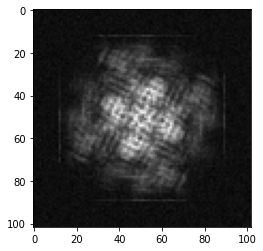

In [ ]:
scale=10
N=200
X = np.zeros((N,)+A.shape)
lam_k=5
true_angles = np.random.uniform(low=0,high=360,size=N)
sigma_shift=1
true_shifts = np.round(np.random.normal(size=2*N,scale=sigma_shift)).astype(int).reshape(N,2) 
noise = np.zeros((N,)+A.shape)
A_true_angle = np.zeros_like(X)
X_aligned = np.zeros_like(X)
for i in range(N):
  #A_true_angle[i] = np.clip(rotate(A,angle=true_angles[0], reshape=False),a_min=0)
  A_unaligned = A
  A_unaligned = rotate(A_unaligned,angle=true_angles[i], reshape=False)
  A_unaligned = shift_zeropad_axis(A_unaligned,true_shifts[i,0],axis=0)
  A_unaligned = shift_zeropad_axis(A_unaligned,true_shifts[i,1],axis=1)
  noise[i] = np.random.poisson(lam=lam_k,size=A.size).reshape(A.shape)
  X[i] = np.random.poisson(lam=A_unaligned*scale + lam_k )
  #X_rot[i] = rotate(X[i], angle=-true_angles[i], reshape=False)
  X_aligned[i] = np.random.poisson(lam=A*scale + lam_k )

A_prev = X_aligned.mean(0)
do_2dplot(A_prev)

In [ ]:
do_2dplot(X_aligned[:10].mean(0))

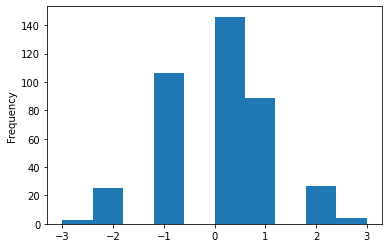

In [ ]:
pd.Series(true_shifts.flatten()).plot.hist()

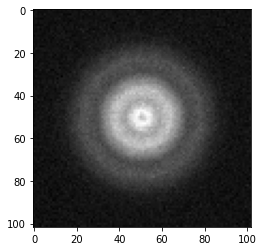

In [ ]:
do_2dplot(X.mean(0))

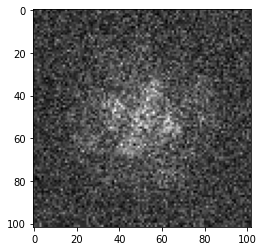

In [ ]:
do_2dplot(X_aligned[0])

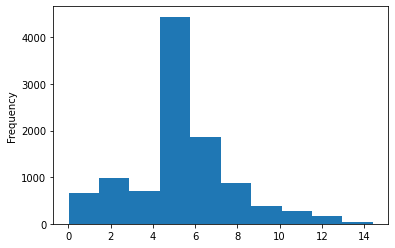

In [ ]:
pd.Series(A_prev.flatten()).plot.hist()

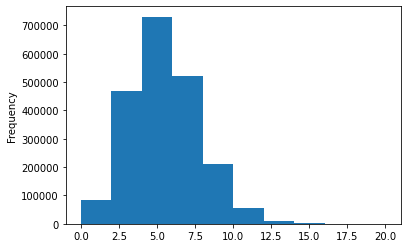

In [ ]:
pd.Series(noise.flatten()).plot.hist() # every value of X always positive

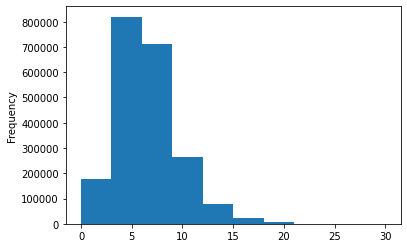

In [ ]:
pd.Series(X.flatten()).plot.hist() # every value of X always positive

## rotate 
* when the particles are randomly rotated (uniform distribution), much of our information washes out

In [ ]:
true_angles = np.random.uniform(0,360,size=N)
for i in range(N): 
  X[i] = rotate(X[i],angle=true_angles[i],reshape=False)
do_2dplot(X.mean(0))

# Guassian to Poisson approximation
The Poisson additive noise model becomes a Gaussian additive noise model in a certain limit, which is explained below.

Let each pixel have poisson signal and noise
$$p(X_{i\alpha}|\lambda) = Poisson(cA_\alpha) + Poisson(\lambda_k) = Poisson(\lambda=cA_\alpha+\lambda_k) = \lambda^{X_{i\alpha}}e^{-\lambda}/X_{i\alpha}!$$

In the limit of large $\lambda$ (> 100), this becomes a Gaussian
$$p(X_{i\alpha}) = \frac
{e^{\frac{-(X_{i\alpha}-cA\alpha-\lambda_k)^2}{2(cA_\alpha+\lambda_k)}}}
{\sqrt{2\pi(cA_\alpha+\lambda_k)}}
$$

Now we extend the typical Gaussian aditive noise model to be the sum of Gaussian signal and noise
$$
X_{i\alpha} = Signal(A_\alpha) + Noise(\sigma^2_n)
$$
Where $Signal(cA_\alpha) \sim N(\mu_{cA_\alpha}=cA_\alpha,\sigma^2_{cA_\alpha}=cA_\alpha)$ and $Noise(\sigma^2_n) \sim N(\mu_n=\lambda_k,\sigma^2_n=\lambda_k)$

Under this extended Gaussian noise model, we can write the probability of observing $X_{i\alpha}$ as a Gaussian, since a sum of Gaussian random variables (plus a constant) is also Gaussian:
$$X_{i\alpha} \sim 
N(\mu_{cA_\alpha}+\mu_n, \sigma^2_{cA_\alpha} + \sigma^2_n) 
= 
N(cA_\alpha + \lambda_k, cA_\alpha + \lambda_k) 
$$
And
$$p(X_{i\alpha}) = \frac
{e^{\frac{-(X_{i\alpha}-cA\alpha - \lambda_k)^2}{2(cA_\alpha+\lambda_k)}}}
{\sqrt{2\pi(cA_\alpha+\lambda_k)}}
$$

This matches with our Poisson probability, at large $\lambda = cA_\alpha+\lambda_k$. But it does not quite look like our familiar white noise Gaussian model, because 1. the there is an extra $\lambda_k$ term in the mean and 2. the variance depends on the signal, which is different in each pixel.

* For 1. We can change the mean by subtracting off $\lambda_k$ from the Gaussian noise model. This is the same thing as centering the noise around a mean of zero, instead of $\lambda_k$. This tells us that we should also subtract off this term in the Poisson noise model, to get the correspondence at large $\lambda$. This would make $X_{i\alpha}$ non Poisson (instead $X_{i\alpha} + \lambda_k$ would be Poisson). Alternatively we could interpret Poisson $X_{i\alpha}$ at large lambda as Gaussian signal and noise (centred at zero), plus a constant.

* For 2. when $\sigma^2_{cA_\alpha}=cA_\alpha<<\lambda_k = \sigma^2_n$, the variance does not have much pixel to pixel dependence and we get back our familiar Gaussian white noise probability. 
$$p(X_{i\alpha}) = \frac
{e^{\frac{-(X_{i\alpha}-cA_\alpha)^2}{2\sigma^2_n}}}
{\sqrt{2\pi\sigma^2_n}}
$$

Note that  $\sigma^2_{cA_\alpha}=cA_\alpha$ changes for each pixel, and there are many pixels where the signal is near zero and the approximation is really good. It's only where the signal is the highest that the approximation is the weakest.

Note that this approximation does not assume that $cA_\alpha$ is large, only that $cA\alpha + \lambda_k$ is large.

We can verify this visually by simulating images under these assumptions with Poisson noise, and comparing them visually to the Gaussian case.






## Poisson

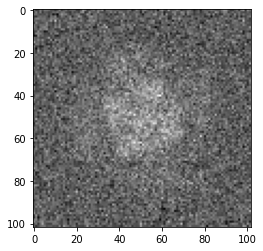

In [139]:
scale=50
N=100
signal = np.zeros((N,)+A.shape)
lam_k=200
true_angles = np.random.uniform(low=0,high=360,size=N)
sigma_shift=1
true_shifts = np.round(np.random.normal(size=2*N,scale=sigma_shift)).astype(int).reshape(N,2) 
noise = np.zeros_like(signal)
A_true_angle = np.zeros_like(signal)
X_aligned = np.zeros_like(signal)
for i in range(N):  
  noise[i] = np.random.poisson(lam=lam_k,size=A.size).reshape(A.shape)
  signal[i] = np.random.poisson(lam=A*scale )
  X_aligned[i] = signal[i] + noise[i]

do_2dplot(X_aligned[i])


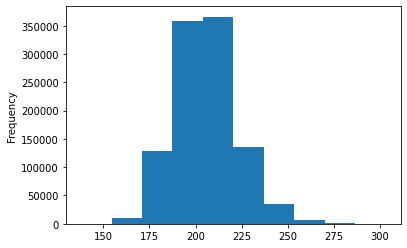

In [140]:
pd.Series(X_aligned.flatten()).plot.hist() # every value of X always positive

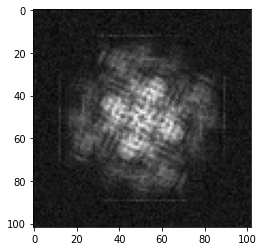

In [141]:
do_2dplot(X_aligned.mean(0))

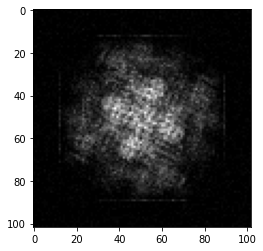

In [142]:
do_2dplot(signal[i])


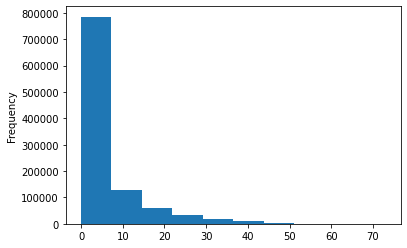

In [143]:
pd.Series(signal.flatten()).plot.hist() # every value of X always positive

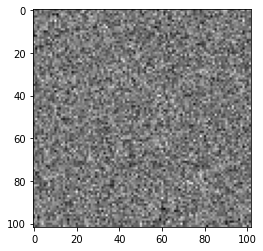

In [144]:
do_2dplot(noise[i])

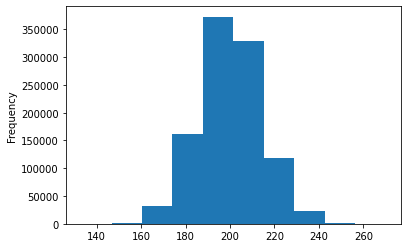

In [145]:
pd.Series(noise.flatten()).plot.hist() # every value of X always positive

## Gaussian

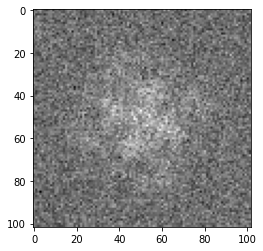

In [146]:
scale=50
N=100
signal = np.zeros((N,)+A.shape)
lam_k=200
true_angles = np.random.uniform(low=0,high=360,size=N)
sigma_shift=1
true_shifts = np.round(np.random.normal(size=2*N,scale=sigma_shift)).astype(int).reshape(N,2) 
noise = np.zeros_like(signal)
A_true_angle = np.zeros_like(signal)
X_aligned = np.zeros_like(signal)
for i in range(N):  
  noise[i] = np.random.normal(loc=lam_k, scale=np.sqrt(lam_k), size=A.size).reshape(A.shape)
  signal[i] = np.random.normal(loc=scale*A, scale=np.sqrt(scale*A))
  X_aligned[i] = signal[i] + noise[i]

do_2dplot(X_aligned[i])


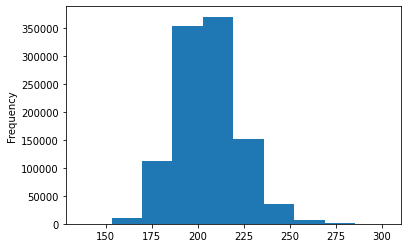

In [147]:
pd.Series(X_aligned.flatten()).plot.hist() 

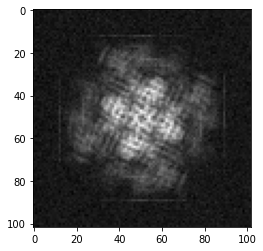

In [148]:
do_2dplot(X_aligned.mean(0))

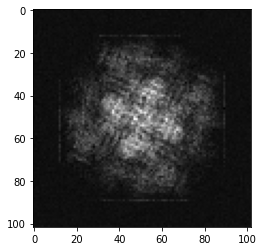

In [149]:
do_2dplot(signal[i])

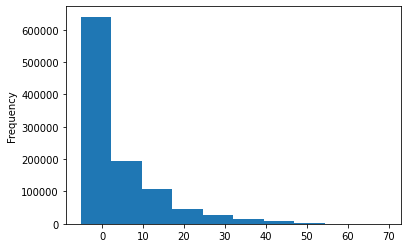

In [150]:
pd.Series(signal.flatten()).plot.hist() 

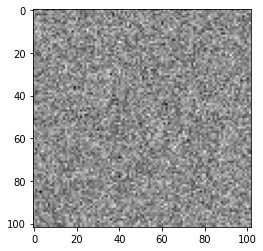

In [151]:
do_2dplot(noise[i])

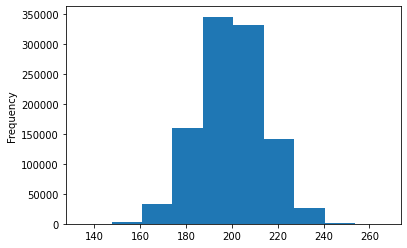

In [152]:
pd.Series(noise.flatten()).plot.hist() 

## Questions to consider
What are the empirical distributions of cryoEM data (micrographs, movies, movie frames?)

If we simulate Poisson data, can we still use an EM algorithm that assumes Gaussian statistics? At what $\lambda$ does this start to break down in practice?

If we do 2D classification on empirical data, and then subtract off the template from the observed, we can get a separate estimate of the signal and noise. How are they distributed empirically?

# 2D Classification: EM Algorithm (with Poisson Additive Noise)
$$
A_\alpha^{\text{new}} = \frac
{
  -N(\ln \lambda + \gamma_{em}) +
  \sum_i Z_i^{-1} \int dq_i \gamma_i \sum_{k=1}^\infty \frac
  {
    X_{i\alpha}
  }
  {
    k(k+X_{i\alpha}-A_\alpha^{\text{old}})
  }
}
{
  \sum_i Z_i^{-1} \int dq_i \gamma_i \sum_{k=1}^\infty \frac
  {
    1
  }
  {
    k(k+X_{i\alpha}-A_\alpha^{\text{old}})
  }
}
$$
* $Z=\int dq_i \gamma_i$
* $\gamma_{em}$ is the [Euler-Mascheroni Constant](https://mathworld.wolfram.com/Euler-MascheroniConstant.html) ($\approx 0.577_2$)
* For the derivative of $(X_{i\alpha}-A_\alpha)!$, see [this video proof from Flammable Maths (2019)](https://youtu.be/kjK9WfmLElo)


Where $\gamma_i$ is given by Poisson statistics
$$\gamma_i = p({\bf q_i})\prod_{\alpha}
\frac{\lambda^{X_{i\alpha}-A_\alpha}e^{-\lambda}}{(X_{i\alpha}-A_\alpha)!} \\ 
$$
* A is modified by the alignment operator, but this is not shown for brevity
* $p({\bf q_i})$ is the prior probability of the alignment ${\bf q_i}$

## Reference aligned templates

In [ ]:
deg_step=1
angles = np.arange(0,360,deg_step)
A_rot = np.zeros((nx,nx,angles.shape[0]))

for angle_idx, angle in enumerate(angles):
  A_rot[:,:,angle_idx] = rotate(A_prev,angle=angle, reshape=False)

In [ ]:
A_aligned_norm = np.sum(A_rot[:,:,:],axis=(0,1))
do_1dplot(A_aligned_norm)

In [ ]:
(A_aligned_norm.max() - A_aligned_norm.min()) / A_aligned_norm.mean() * 100

## $\gamma_i$
$$\gamma_i = \prod_\alpha \lambda^{X_{i\alpha}-A_\alpha}e^{-\lambda} / (X_{i\alpha}-A_\alpha)!$$

In [ ]:
x=X[0]
x_minus_A = np.abs((x-A_rot[:,:,1]))
np.power(lam,x_minus_A.sum(), dtype=np.float128), x_minus_A.sum()

In [ ]:
pi_a_ = np.power(lam,x_minus_A)*np.exp(-lam)/gamma(x_minus_A)
do_2dplot(pi_a_)

In [ ]:
pd.Series(pi_a_.flatten()).plot.hist()

In [ ]:
gi = np.prod(pi_a_, dtype=np.float128) ; gi

In [ ]:
np.exp(np.sum(np.log(pi_a_, dtype=np.float128), dtype=np.float128), dtype=np.float128)

Good news: computing the product sum at this point looks numerically stable. In case it wasn't we could have computed things inside the kernal of the product sum on term at a time.

In [ ]:
np.power(lam,x_minus_A[0,0], dtype=np.float128)

In [ ]:
np.exp(-lam,dtype=np.float128)

In [ ]:
from scipy.special import gamma

gamma(x_minus_A.max()+1), gamma(x_minus_A.min()+1)

The gamma term blows things up in extremely realistic situations. We have to keep an eye on it, or consider encoding it as an integer for more precision.

In [ ]:
np.sum(gamma(x_minus_A+1),dtype=np.float128)

In [ ]:
do_2dplot(gamma(x_minus_A+1))

In [ ]:
log_gamma_i_kernel = x_minus_A*np.log(lam)-lam - gamma(x_minus_A+1)
do_2dplot(log_gamma_i_kernel)

Let's check that everything is finite, and we are not having numerical issues.

In [ ]:
#x_minus_A[~np.isfinite(gamma(x_minus_A+1))]
x_minus_A[~np.isfinite(log_gamma_i_kernel)]

The gamma function should not be taking negative values, as it may give complex infinity at these points. We cannot use the Poisson distribution formula to model noise that is not positive. The formula is not valid for negative values of k (k! is not defined).

The values in `log_gamma_i_kernel` are not that large, but the sum is over so many pixels, that it cannot be exp-ed with numerical stability.

Instead we can divide out a common factor from the $\gamma_i$ terms. We can look at the range of $\gamma_i$ for all the alignments and normalize things so we are within range for the most likely ones. 

In [ ]:
pd.Series(log_gamma_i_kernel.flatten()).plot.hist()
log_gamma_i_kernel.sum()

## $\gamma_i$ vectorized over alignments

In [ ]:
x=X[0]
x_minus_A = np.abs((x.reshape(x.shape+(1,))-A_rot))
x_minus_A.shape

In [ ]:
pd.Series(x_minus_A.flatten()).plot.hist()

How do we go further at this point? It's confusing because the rotations make the noise be negative, and the Poisson statistice break down. 

Perhaps we could introduce a heuristic, that any alignments where the difference is negative have zero probability. But then we see that only the first perfectly aligned template satisfies this.

In [ ]:
x_minus_A.min(axis=(0,1)) < 0

In [ ]:
log_gamma_i_kernel = x_minus_A*np.log(lam)-lam - gamma(x_minus_A+1)
log_gamma_i_kernel.min(), log_gamma_i_kernel.max(), gamma(x_minus_A+1).max(), gamma(x_minus_A+1).min()

In [ ]:
x_minus_A.max(), x_minus_A.min()

We need x_minus_A to be quite small, in order to be able to handle the factorial/gamma of it. Just one term can blow up quicky. This comes down to the size of k... we have to have k very low

In [ ]:
pd.Series([gamma(x+1) for x in range(15)]).plot()

In [ ]:
log_gamma_i_kernel_sum = log_gamma_i_kernel.sum(axis=(0,1))
log_gamma_i_kernel_sum_stable = (log_gamma_i_kernel_sum - log_gamma_i_kernel_sum.max())
np.logical_and(log_gamma_i_kernel_sum_stable <= 11355, log_gamma_i_kernel_sum_stable >= -11380) # stable?

In [ ]:
log_gamma_i_kernel_sum_stable.astype(int)

In [ ]:
gi = np.exp(log_gamma_i_kernel_sum_stable, dtype=np.float128)
pd.Series(gi).plot()

This peaked distribution means that only this alignment is likely. There seems to be no parameter governing the spread of $\gamma_i$, everything is dominated

## Precompute $\sum_k$ terms
* consider making a `ufunc`, so can use on vector of $X_i-A$ (over all $\alpha$ values). If we only have a few values of `x_minus_A`, then we can precompute for these values of k and look them up in a table.
* Actually these have been calculated analytically (taking k to infinity in [this online Series Calculator](https://www.symbolab.com/solver/series-calculator))

|x|ksum|
|-|-|
|1|1|
|2|3/4|
|3|11/18|
|4|25/48|
|5|137/300|
|6|49/120|
|k|$H_k/k$ ($H_k$ is the $k$th Harmonic number)|

In [ ]:
x = X[0]
k_poisson = x_minus_A
pd.Series(k_poisson.flatten()).plot.hist()

In [ ]:
do_2dplot(k_poisson)

In [ ]:
kpa = 5#k_poisson[0,0]
k = np.arange(1,100,1)
kseries = 1/(k*(k+kpa))
pd.Series(kseries).plot()
kseries.sum()

def ksum(k,x): 
  '''
  k is over 1 to infinity. in practice truncate at k=100, etc
  '''
  return(np.sum(np.power(k*(k+x),-1,dtype=np.float128)))
  #return((1/(k*(k+x))).sum())

def ksum_analytic(x):
  '''
  when x is an integer we can use the analytical result. See https://www.wolframalpha.com/input/?i=infinite+series&assumption=%7B%22F%22%2C+%22Sum%22%2C+%22sumlowerlimit%22%7D+-%3E%221%22&assumption=%7B%22C%22%2C+%22infinite+series%22%7D+-%3E+%7B%22Calculator%22%7D&assumption=%7B%22F%22%2C+%22Sum%22%2C+%22sumfunction%22%7D+-%3E%221%2F%28x*%28x%2Bk%29%29%22&assumption=%7B%22F%22%2C+%22Sum%22%2C+%22sumupperlimit2%22%7D+-%3E%22infinity%22
  '''
  if np.isclose(x,0): return(np.pi**2/6)
  Hx = (1/np.arange(1,x+1)).sum()
  return(Hx/x)
ksum(k,1)

In [ ]:
x_minus_A_uniq = np.unique(x_minus_A)
precomputed_ksum = np.zeros(x_minus_A_uniq.shape[0], dtype=np.float128)
for i in range(precomputed_ksum.shape[0]):
  precomputed_ksum[i] = ksum(k,x_minus_A_uniq[i])
#precomputed_ksum = {x: ksum_analytic(x) for x in np.unique(x_minus_A)}


In [ ]:
pd.Series(precomputed_ksum).plot.hist()

We can compare this to the result using the truncated ksum function.

# 2D Classification: EM Algorithm (with Poisson Additive Signal and Noise)
* Previously the factorial of $(X_{i\alpha}-A_\alpha)!$ caused many numerical issues. We could not just factor it out of $\gamma_i$, because it was different for each alignment and had to be computed.
* Does is make sense to instead have the poisson parameter $k=X_{i\alpha}$? Before the noise was Poisson, and we had a scaled background of A, but what if each pixel has its own poisson noise ($\lambda=cA_\alpha$), coming from the signal itself, plus some shared background noise ($\lambda=\lambda_k$). In this case X is Poisson with $\lambda=cA_\alpha+\lambda_k$.
* $X_{i\alpha} = Signal_{poisson}(cA_\alpha) + Noise_{poisson}(\lambda_k)$
  * Beacause $X_i$ is explicity the sum of two poissons, and the signal is not just a floating point constant, it it always an integer. We can leverare this when we encode it for numerical stability, memory, etc.
  * The average of $X_i$ will likely be floating point, because we are dividing by the number of particles, but it will always be positive, since $X_i$ is positive integers
* $Prob(X_{i\alpha}|A_\alpha) = Poisson(k=X_{i\alpha} | \lambda=A_\alpha + \lambda_k)$
  * Note that this uses a different $\lambda$ for each pixel, arising from the underlying signal of the image
$$A_{\alpha} = (cN)^{-1}\sum_i \frac{
  \int dq_i \gamma_i X_{i\alpha}}
  {\int dq_i \gamma_i} - \lambda_k/c
  $$
Where $\gamma_i$ is given by Poisson statistics
$$\gamma_i = p({\bf q_i})\prod_{\alpha}
\frac{A_\alpha^{X_{i\alpha}}e^{-A_\alpha}}{X_{i\alpha}!} \\ 
= p({\bf q_i})
e^{-\sum_\alpha A_\alpha}
\prod_{\alpha}
\frac{A_\alpha^{X_{i\alpha}}}{X_{i\alpha}!}
$$
* A is modified by the alignment operator, but this is not shown for brevity
* $p({\bf q_i})$ is the prior probability of the alignment ${\bf q_i}$
* For numerical stability the $\prod_{\alpha}X_{i\alpha}$ can be factored out of each $\gamma_i$, assuming it is constant over alignments (neglecting interpolation errors at the different alignments)

## Reference aligned templates
* Also compute sums over all pixels (instead of norm)

### window
Need to circularly window to prevent normalizatoins from being difference because of clipping from the rotations.

In [ ]:
bool_circle_mask = ~cmask(index=(nx//2,nx//2),radius=int(nx//2*0.90),array=np.ones_like(A_prev)).astype(np.bool)
do_2dplot(bool_circle_mask)


In [ ]:
deg_step=1
angles = np.arange(-180,180,deg_step)
#A_rot = np.zeros((nx,nx,angles.shape[0]))
A_prev_wind = A_prev.copy()


# shift
shift_span = 0.001
shifts_r = np.zeros(1)#np.arange(-shift_span+1,shift_span, dtype=np.int32)
shifts_c = np.zeros(1)#np.arange(-shift_span+1,shift_span, dtype=np.int32)

A_align = np.zeros((nx,nx,angles.shape[0],shifts_r.shape[0],shifts_r.shape[0] ))

for shift_r_idx, shift_r in enumerate(shifts_r):
  A_shift_r = shift_zeropad_axis(A_prev_wind,shift=shift_r,axis=0)
  for shift_c_idx, shift_c in enumerate(shifts_c):
    A_shift_r_c = shift_zeropad_axis(A_shift_r,shift=shift_c,axis=1)
    for angle_idx, angle in enumerate(angles):
      #A_shift_r_c[bool_circle_mask] = 0
      A_align[:,:,angle_idx,shift_r_idx,shift_c_idx] = rotate(A_shift_r_c,angle=angle, reshape=False)



pd.Series(A_align.flatten()).plot.hist()

In [ ]:
do_2dplot(A_align[:,:,5,0,0])

In [ ]:
A_aligned_norm = A_align[~bool_circle_mask].sum(0).flatten()
do_1dplot(A_aligned_norm)



In [ ]:
(A_aligned_norm.max() - A_aligned_norm.min()) / A_aligned_norm.mean() * 100

0.004642630330917609

The sums of A fluctuate, much less than 1% error, which is almost nothing! Without windowing, there are large fluctuations.

## $\gamma_i$
* Numerical stability
  * Note that the $\prod_\alpha X{i \alpha}!$ in $\gamma_i$ can be factored out of the integral. There is one in the numerator and denomenator of the update equation for $A_\alpha$, which cancel out with each other.
  * Therefore we compute a scaled $\gamma_i$ below, without this factor
  * If x has some outlier values, then they can swamp the scales of things being computed (keep an eye on these pixels when developing). 

In [ ]:
x = X_aligned[0].copy()
x[bool_circle_mask] = 0

do_2dplot(x)
x.mean(), x.std()**2, x.max()

In [ ]:
pd.Series(x.flatten()).plot.kde()

### $(cA_\alpha+\lambda)^{X_{i \alpha}}$
* Note that `np.power(0,0) = 1` by definition, and it works the same way on vectors.

In [ ]:
lamtok = np.power(A_prev+lam_k,x)
do_2dplot(lamtok)
lamtok.max()

In [ ]:
do_2dplot(np.isclose(A_prev+lam_k,0))
np.isclose(A_prev+lam_k,0).sum()
np.prod(A_prev+lam_k, dtype=np.float128)

In [ ]:
pd.Series(lamtok.flatten()).plot.kde()

The outier comes from a large value in $X_i$. Most the the values are low integers, but there is an outlier. This will get worse as the signal to noise improves. As there a lot of pixels and alot of images, this is bound to happen.

To use `np.prod` and not have things round to zero, we need to encode more than the default of `np.float64`. Including the detector noise is the same as having a heuristic of addint in a small term to A to offset zeros. I.e. if $A$ had zeros (it won't), we could have modified it to have a small term constant term to offset zeros, effectively guaranteeing that it is always positive. But what number to pick? We could have used the number closest to zero, for instance. Note this heuristic lead me to posit the shared poisson noise in the noise model, which is more principled and has an interpretability.

In [ ]:
# A_nonzero_min = A_prev[A_prev>0].min()
# A_prev[np.isclose(A_prev,0)] = A_nonzero_min

In [ ]:
# Atox = np.power(A_prev,x)
# do_2dplot(Atox)
# Atox.min(), Atox.max(), np.prod(Atox)

###$e^{-(cA_\alpha-\lambda_k)}$
* We can either compute this within the product sum, by multiplying it with $A_\alpha^{X_{i \alpha}}$, or we can pull it out of the product sum and sum over alpha, $e^{-\sum_\alpha A_\alpha}$

In [ ]:
etolam = np.exp(-A_prev-lam_k)
do_2dplot(etolam)

In [ ]:
etolam.min(), etolam.max()

In [ ]:
np.prod(etolam.astype(np.float128), dtype=np.float128)

In [ ]:
lamsum = A_prev.sum() + lam_k*A.size ; lamsum

In [ ]:
np.exp(-lamsum, dtype=np.float128)

We have a problem, because we can only compute $[e^{-745},e^{709}]$ in default precision.

However, if we encode a number as `np.float128` we can reach at least $[e^{-11380},e^{11355}]$

* See discussion https://stackoverflow.com/questions/40726490/overflow-error-in-pythons-numpy-exp-function

In [ ]:
dom = np.linspace(0,11380,100, dtype=np.float128)
#sr = pd.Series((np.isclose(np.exp(-dom),0)).astype(np.int))
sr = pd.Series(np.log(np.exp(-dom)))
sr.index = dom
sr.plot()
np.log(np.exp(np.float128(-11380))), np.log(np.exp(np.float128(-11400))),\
np.log(np.exp(np.float64(-745))), np.log(np.exp(np.float64(-746)))


In [ ]:
dom = np.linspace(0,11355,100, dtype=np.float128)
#sr = pd.Series((np.isclose(np.exp(-dom),0)).astype(np.int))
sr = pd.Series(np.log(np.exp(dom)))
sr.index = dom
sr.plot()
np.log(np.exp(np.float128(11355))), np.log(np.exp(np.float128(11360))),\
np.log(np.exp(np.float64(709))), np.log(np.exp(np.float64(710)))


If we try to compute $(cA_\alpha+\lambda_k)^{X_{i\alpha}}e^{-(cA_\alpha+\lambda_k)}$ together, pixel by pixel, we may have a hard time taking the product after, since the values are too small.

In [ ]:
numerator = lamtok*etolam
do_2dplot(numerator)
numerator.min(), numerator.max(), numerator.mean(), np.prod(numerator,dtype=np.float128)


In [ ]:
pd.Series(numerator.flatten()).plot.hist()

In [ ]:

do_2dplot(AxeA / AxeA.min() / AxeA.size)
np.prod(AxeA / AxeA.min() / AxeA.size)

### Numerical stability
* there are two basic approaches for numerical stability. Google [logsumexp](https://en.wikipedia.org/wiki/LogSumExp)
  * exp log for large values
  * log exp for small values
* $\gamma_i$ is too small here, so let's use $log$ to break up the product sum
$$
\gamma_i = e^{[\ln \gamma_i]}
$$
$$\ln[\prod_\alpha (cA_\alpha+\lambda_k)^{X_{i \alpha}}e^{-(cA_\alpha+\lambda_k)}] \\
= \sum_\alpha X_{i \alpha} \ln[cA_\alpha+\lambda_k] - (cA_\alpha+\lambda_k)
$$
* I can offset this sum by a constant, K, chosen such that the number that will be exp-ed is within the numerically stable range
$$K_i \text{ s.t. } = \sum_\alpha X_{i \alpha} \ln[cA_\alpha+\lambda_k] - (cA_\alpha+\lambda_k) - K_i \in [-11380,+11355] \text{ over alignments}$$

The log is not blowing up to negative infinity

In [ ]:
do_2dplot(np.log(A_prev+lam_k))
np.log(A_prev+lam_k).min(), np.log(A_prev+lam_k).max()

In [ ]:
log_gi = x*np.log(A_prev+lam_k) - A_prev-lam_k
do_2dplot(log_gi)
log_gi.max(), log_gi.min(), log_gi.sum()


In [ ]:
pd.Series(log_gi.flatten()).plot.hist()

Now we can do a sum before taking the exp.

In [ ]:
gi = np.exp(log_gi.sum(), dtype=np.float128)
log_gi.sum(), gi

To recover $\gamma_i$ we have to exp this. However, we can factor out a very small number in the numerator and denomenator of the $A_\alpha$ update equation, for each image $i$. We first compute $\ln \gamma_i$ over all alignments, then subtract off the same value for all alignments to bring their values in range where we can exp them and preserve the numerical preision of them. Subtracting off a value in the exp is the same as factoring out a multiplicative constant. This does nothing since we are using gamma to update $A\alpha$ and it is in botht the numerator and denomenator.

## $\gamma_i$ vectorized over alignments
* We need to apply masking, to ignore the edge effects. We only count pixels in the centre of the particle box, away from the edges.

In [ ]:
i=0
x = X_aligned[i].copy()
#x[bool_circle_mask] = 0
do_2dplot(x)

In [ ]:
log_lamtok = x[~bool_circle_mask].reshape(x[~bool_circle_mask].shape+(1,1,1,))*np.log(A_align[~bool_circle_mask]+lam_k)
pd.Series(log_lamtok.sum(0).flatten()).plot.kde()


In [ ]:
pd.Series(log_lamtok.sum(axis=0).flatten()).plot()

The $\sum_\alpha X_{i \alpha} \ln[cA_\alpha+\lambda_k]$ terms contribute a + amount to the total $\ln \gamma_i$ sum, depending on the alignment. The poisson distribution is a tug of war between the $\lambda^k$ and the $e^{-\lambda}$, so the $\sum_\alpha - (cA_\alpha+\lambda_k)$ terms should have an opposite sign.

Note that outside the mask $A$ is zero, but there is still a contribution because $X$ has not been mased and there is the $\lambda_k$ inside the log. However this is constant over alignments, and won't effect how the updated value of $A_\alpha$. Any constant over alignments will be absorbed into $K_i$.

In [ ]:
log_etolam = -(A_align[~bool_circle_mask].sum(axis=(0))+(lam_k)*A.size) # the mask collapses the two xy image axes into one
pd.Series(log_etolam.flatten()).plot.kde()

In [ ]:
pd.Series(log_etolam.flatten()).plot()

Yes! We see the sign is opposite. Perhaps it makes sense to compute things like this for numerical stability, because it puts terms with the same trend together through addition/subtraction so differences aren't washed out through multiplying/dividing.

All in all this term does not change much at all for alignments. That makes sense bcause of the circular windowing we did.

This term is dominating the sum, with values in between -14000 and -12000. Usually the factorial term balances things out so the probability normalizes, but we have factored out that term.

In [ ]:
log_gi_align = log_lamtok.sum(axis=0) + log_etolam
pd.Series(log_gi_align.flatten()).plot.kde()


This is a good time to troubleshoot. The gamma represents is a Bayesian belief in the alignments. If it does not make sense at this point there may be issues (e.g. rotations clipping values... solved by circular windowing)

Let's take our first look over the alignments and see if it is working. $A$ and $X_i$ were aligned, so the best angles should be around 0 and 360 (the end points). This is still in log space, so the actual probability will be (dramatically) more peaked. Pay attention to the scale on the y axis, but only up to a constant (not scaled, the actual scale of the numbers matter).

In [ ]:
pd.Series(log_gi_align.flatten()).plot()

#### $K_i$
* K should be the same for i, but can change between i
* K should not depend on the alignment, so it can be taken out of the integral over alignments
* We can just subtract off the max and scale the largest to zero, or we can bump that higher, in case the lower bound is too negative and beyond numerical precision. However, it's a good idea to have more sensitivity around the likely (high probability) values, and this happens around zero.

In [ ]:
log_gi_align_stable = log_gi_align - log_gi_align.max()
pd.Series(log_gi_align_stable.flatten()).plot()

In [ ]:
gi_stable = np.exp(log_gi_align_stable, dtype=np.float128)
pd.Series(gi_stable.flatten()).plot()
pd.Series(gi_stable.flatten()).sort_values().round(2)

The distributions are very sparse. So perhaps the update could leverage this and only use these alignment values for further computations (with this particle and template iteration pair)

### Prior over shifts

In [ ]:
log_prior_shift = np.zeros_like(log_gi_align)
for shift_r_idx in range(shifts_r.shape[0]):
  for shift_c_idx in range(shifts_c.shape[0]):
    q2 = shifts_r[shift_r_idx]**2+shifts_c[shift_c_idx]**2
    log_prior_shift[:,shift_r_idx,shift_c_idx] = -q2/(2*sigma_shift**2)
pd.Series(log_prior_shift.flatten()).plot()

Depending on the $\sigma_q$, the distibutions will be more peaky (larger $\sigma_q$, more undertainty, broader distribution, should search over more shifts (which takes longer)). 

### $\gamma_i(\lambda_k)$
* The size of lambda effects the sensitivity of the alignments. When we have more noise, the undertainty of the alignments goes up, and the distributions are blunt rather than peaked

In [ ]:
i=1
x = X_aligned[i].copy()
#x[bool_circle_mask]=0
do_2dplot(x)
true_shifts[i]

In [ ]:
pd.Series(x.flatten()).plot.hist()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


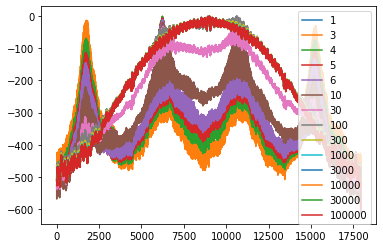

In [ ]:
for lam_k_ in [1,3,4,5,6,10,30,100,300,1000,3000,10000,30000,100000]:
#  log_lamtok = x.reshape(x.shape+(1,1,1,))*np.log(A_align+lam_k_) #abs hack
  log_lamtok = x[~bool_circle_mask].reshape(x[~bool_circle_mask].shape+(1,1,1,))*np.log(A_align[~bool_circle_mask]+lam_k_)
  #log_etolam = -(A_align.sum(axis=(0,1)))#+(lam_k_)*A.size)
  log_etolam = -(A_align[~bool_circle_mask].sum(axis=0)+(lam_k_)*A_align[~bool_circle_mask].size) # the mask collapses the two xy image axes into one

  #log_gi_align = log_lamtok.sum(axis=(0,1)) + log_etolam
  log_gi_align = log_lamtok.sum(axis=0) + log_etolam + log_prior_shift
  Ki = log_gi_align.max()
  log_gi_align_stable = log_gi_align - Ki
  gi_stable = np.exp(log_gi_align_stable, dtype=np.float128)
  pd.Series(log_gi_align_stable.flatten()).plot(label=lam_k_,legend=True)
  #pd.Series(gi_stable.flatten()/gi_stable.flatten().max()).plot(label=lam_k_,legend=True)
  #pd.Series(log_etolam.flatten()-log_etolam.max()).plot(label=lam_k_,legend=True)
  #pd.Series(log_lamtok.sum(axis=(0,1)).flatten()-log_lamtok.sum(axis=(0,1)).max()).plot(label=lam_k_,legend=True)


Different $\lambda$s can give rise to different trends, because at some point the scale of one of the terms dominates another and its trend is emphasized
  * Lower $\lambda$ blunts $\lambda^k$ in log space
  * $\lambda$ scales $e^{-\lambda}$ by a multiplicative factor, which is a constant in log space

The $\prod_\alpha e^{-\lambda_k} = e^{-M\lambda_k}$ factor does is constant over alignments, and so can be factored out / dropped.

If the masking is being clipped by the shifts, the sum of the aligned template can really start preferring certain alignments, just because there is more signal. There should be full signal where things are computed. Without this the alignment prefers higher lower/shifts and flip flops each iteration with the template. This causes the template to jump around each iteration.



In [ ]:
angle_idx,shift_r_idx,shift_c_idx = np.unravel_index(np.argmin(log_etolam, axis=None), log_etolam.shape)
do_2dplot(A_align[:,:,angle_idx,shift_r_idx,shift_c_idx])

In [ ]:
angle_idx,shift_r_idx,shift_c_idx = np.unravel_index(np.argmax(log_etolam, axis=None), log_etolam.shape)
do_2dplot(A_align[:,:,angle_idx,shift_r_idx,shift_c_idx])

In [ ]:
do_2dplot(A_align[:,:,-0,0,0])

## Reverse the alignment
During the interpolation the values are no longer integers. This is not a problem, it just makes the update of A be floating point. That was going to happen anyways because the update multiplies the rotated x by floating point factors.

However the rotation keeps the mean constant by scaling things a bit and the min and max are changed. The min can be negative now! So we'll have to keep an eye on updated values of A that are negative or zero, in case they cause problems. Otherwise we can change how the rotations are interpolated.

In [ ]:
def comp_x_aligned(x,A_rot_shifted,angles,shifts_r,shifts_c):
  x_aligned = np.zeros(A_rot_shifted[:,:,:,:,:].shape)
  for angle_idx in range(angles.shape[0]):
    x_rot = scipy.ndimage.rotate(x,angle=-angles[angle_idx],reshape=False) 
    for shift_r_idx in range(shifts_r.shape[0]):
      x_rot_shift = shift_zeropad_axis(x_rot,shift=-shifts_r[shift_r_idx],axis=0)
      for shift_c_idx in range(shifts_c.shape[0]):
          x_aligned[:,:,angle_idx,shift_r_idx,shift_c_idx] = shift_zeropad_axis(x_rot_shift,shift=-shifts_c[shift_c_idx],axis=1)
  return(x_aligned)

In [ ]:
# x_aligned = np.zeros_like(A_rot)
# x[bool_circle_mask] = 0
# for angle_idx in range(angles.shape[0]):
#       x_aligned[:,:,angle_idx] = rotate(x,-angles[angle_idx],reshape=False) 
x = X_aligned[0].copy()
x_aligned = comp_x_aligned(x,A_align,angles,shifts_r,shifts_c)
x_aligned[:,:][bool_circle_mask] = 0

In [ ]:
do_2dplot(x_aligned[:,:,0,0,0]) # masking should be centred

In [ ]:
pd.Series(x_aligned.min(axis=(0,1)).flatten()).plot.kde()
x.min()

## Maximization (Update A)

In [ ]:
Ui = gi_stable.sum()**-1

A_next = Ui*np.multiply(gi_stable.reshape((1,1,)+gi_stable.shape),x_aligned).sum(axis=(-1,-2,-3))
do_2dplot(A_next)

In [ ]:
pd.Series(A_next.flatten()).plot.kde()
pd.Series(A_next.flatten()).round(3).sort_values()

## Log liklihood
The log liklihood is useful to compute for at least two reasons
1. We can track it (over iterations? over observed images?) and see that it is always increasing
2. From it we can recover an unnormalized probability, so we can take ratios and get probabilities

$$L = \ln p(A|data) \\
= \sum_i Ki + \ln \int dq_i \gamma_i^\prime - \sum_\alpha \ln X_{i\alpha}!
$$
* where $\gamma_i^\prime=\gamma_i e^{-K_i}/\prod_\alpha X_{i\alpha}!$
* $K_i$ and $\prod_\alpha X_{i\alpha}!$ do not depend on the alignment and can be factored out of the integral

* $\prod_\alpha X_{i\alpha}!$ can be computed fast by precomputing terms in a look up table. This is because there will only be a few values of $\alpha$ at low dose.
  * $0! := 1 \implies \ln0! := 0$

In [ ]:

def sum_ln_factorial(x):
  '''
  sum log of lectron count factorial over pixels
  precompute pixel_values and their counts 
  sum_a ln Xia!
  '''
  
  value_counts = pd.Series(x.astype(np.uint64)[x>1]).value_counts() # 0 and 1 contribute nothing to sum
  pixel_values = value_counts.index.values.astype(np.uint64)
  counts = value_counts.values.astype(np.uint64)
  lnxia = 0
  for pixel_value, count in zip(pixel_values, counts):
    lnxia += count*np.math.factorial(pixel_value)
  return(lnxia)
sum_ln_factorial(x)

## Iterative update
* Does this work with a random initialization?
* How many particles are needed and at what noise level?
* How many iterations are needed?
* distribution of best probabilities (have to normalize $\gamma_i$)
* What do the true angle vs estimated (best) angles look like?

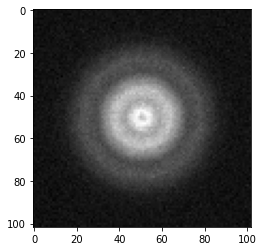

In [ ]:
A_prev = X.mean(0)
A_next = A_prev.copy()
do_2dplot(A_prev)

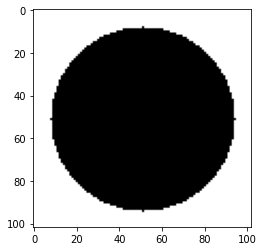

In [ ]:
bool_circle_mask = ~cmask(index=(nx//2,nx//2),radius=int(nx//2*0.85),array=np.ones_like(A_prev)).astype(np.bool)
do_2dplot(bool_circle_mask)

In [ ]:
deg_step = 0.5
angles = np.arange(1,360,deg_step) # TODO: test no zero rotation in case not interpolating same way

shift_span = np.abs(true_shifts).max()
shifts_r = np.arange(-shift_span+1,shift_span, dtype=np.int32)
shifts_c = np.arange(-shift_span+1,shift_span, dtype=np.int32)
if shift_span==0: 
  shifts_r = np.array([0])
  shifts_c = np.array([0])
shift_span

3

0
i = 0, ll = -519503550.10, A_next min=1.71, max=16.91
i = 20, ll = -10909572346.65, A_next min=85.31, max=301.97
i = 40, ll = -21299637024.63, A_next min=182.68, max=592.35
i = 60, ll = -31689701771.37, A_next min=276.59, max=875.96
i = 80, ll = -42079768935.73, A_next min=372.71, max=1125.04
i = 100, ll = -52469837018.92, A_next min=463.72, max=1399.47
i = 120, ll = -62859901635.32, A_next min=563.90, max=1670.80
i = 140, ll = -73249967704.41, A_next min=658.87, max=1949.77
i = 160, ll = -83640034457.36, A_next min=749.00, max=2207.83
i = 180, ll = -94030099971.62, A_next min=848.42, max=2464.89
1
i = 0, ll = -519503485.94, A_next min=0.83, max=20.39
i = 20, ll = -10909571075.23, A_next min=81.77, max=324.77
i = 40, ll = -21299634602.97, A_next min=174.11, max=595.31
i = 60, ll = -31689698124.76, A_next min=266.45, max=906.91
i = 80, ll = -42079764056.14, A_next min=355.87, max=1183.28
i = 100, ll = -52469830967.36, A_next min=462.31, max=1453.83
i = 120, ll = -62859894382.07, A_nex

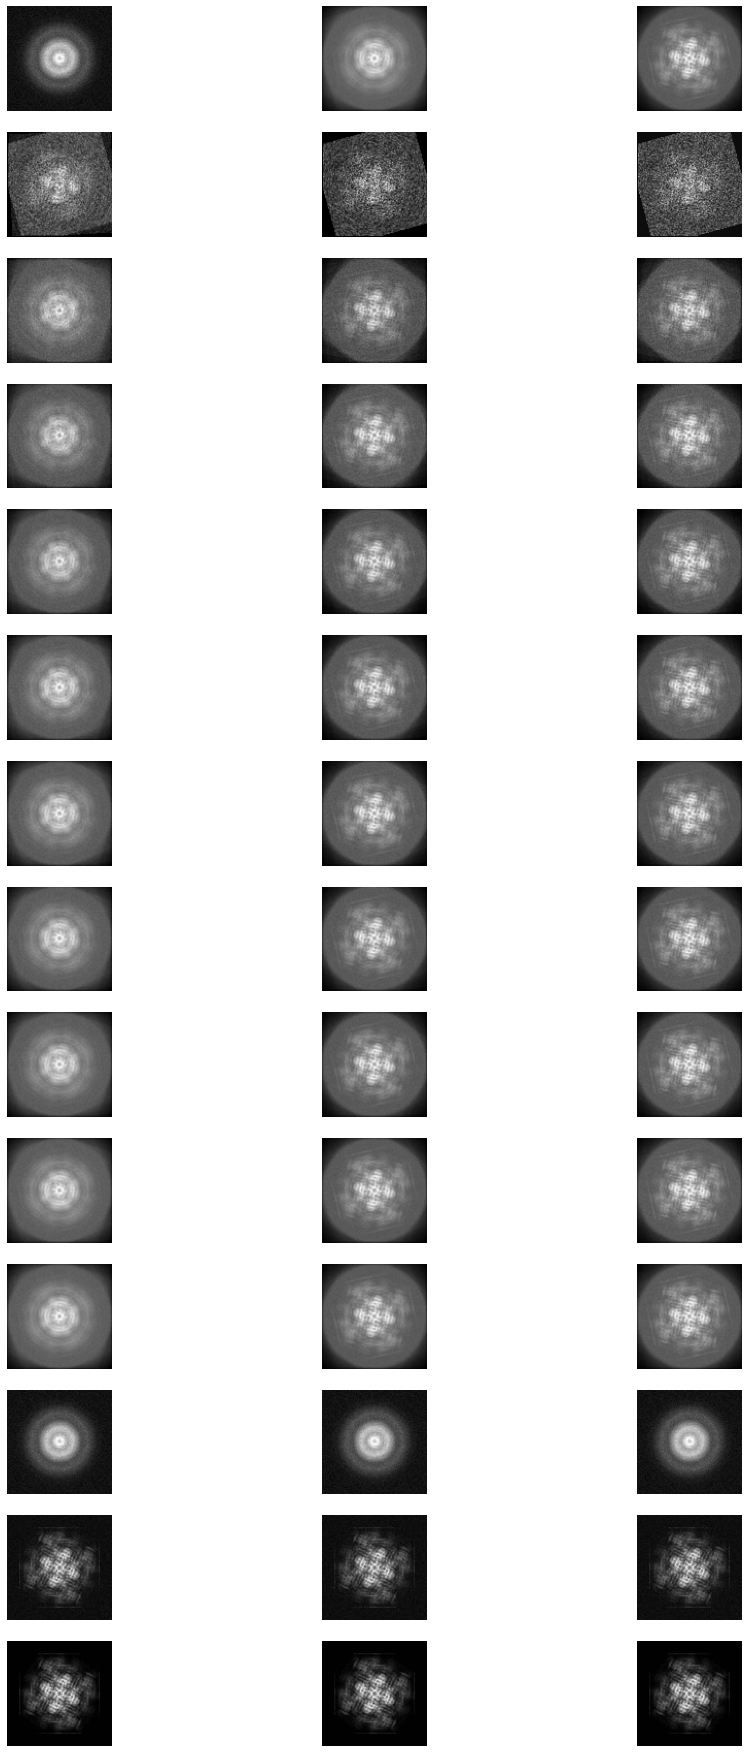

In [ ]:
small_N = X.shape[0]
n_A_updates=3

# initialize
A_align = np.zeros((nx,nx,angles.shape[0],shifts_r.shape[0],shifts_r.shape[0] ))
x_aligned = np.zeros_like(A_align)
best_X = np.zeros((n_A_updates,small_N,nx,nx))
best_angles, best_shift_rs, best_shift_cs = np.zeros((n_A_updates,small_N)), np.zeros((n_A_updates,small_N)), np.zeros((n_A_updates,small_N))
LL = np.zeros((n_A_updates,small_N))

fig, axes = plt.subplots(min(10,small_N)+4, n_A_updates,figsize=(16,32))

for c in range(n_A_updates):
  print(c)
  
  ll=0
  A_prev = A_next.copy()
  A_next = np.zeros_like(A_prev)

  axes[0,c].imshow(A_prev,cmap='gray') ; axes[0,c].set_axis_off()

  # reference alignments of template
  for shift_r_idx, shift_r in enumerate(shifts_r):
    A_shift_r = shift_zeropad_axis(A_prev,shift=shift_r,axis=0)
    for shift_c_idx, shift_c in enumerate(shifts_c):
      A_shift_r_c = shift_zeropad_axis(A_shift_r,shift=shift_c,axis=1)
      for angle_idx, angle in enumerate(angles):
        A_shift_r_c[bool_circle_mask] = 0 # TODO test if interpolation different with windowing
        A_align[:,:,angle_idx,shift_r_idx,shift_c_idx] = rotate(A_shift_r_c,angle=angle, reshape=False)
  
  # terms that only depends on A
  A_align[~bool_circle_mask][A_align[~bool_circle_mask] < 0] = A_align[~bool_circle_mask][A_align[~bool_circle_mask] < 0].min() # hack
  log_lam = np.log(A_align[~bool_circle_mask]+lam_k)
  # table of norms
  log_etolam = -(A_align[~bool_circle_mask].sum(axis=0)+(lam_k)*A_align[~bool_circle_mask].size) # the mask collapses the two xy image axes into one
 
  # pdf shifts, shift prior
  log_prior_shift = np.zeros_like(A_align[0,0])
  for shift_r_idx in range(shifts_r.shape[0]):
    for shift_c_idx in range(shifts_c.shape[0]):
      q2 = shifts_r[shift_r_idx]**2+shifts_c[shift_c_idx]**2
      log_prior_shift[:,shift_r_idx,shift_c_idx] = -q2/(2*sigma_shift**2)

  r=0
  for i in range(small_N):
    #print('image %i'%i)
    x = X[i]
        
    #Ki, gi
    log_lamtok = x[~bool_circle_mask].reshape(x[~bool_circle_mask].shape+(1,1,1,))*log_lam
    log_gi_align = log_lamtok.sum(axis=0) + log_etolam + log_prior_shift
    Ki = log_gi_align.max()
    log_gi_align_stable = log_gi_align - Ki
    gi_stable = np.exp(log_gi_align_stable, dtype=np.float128)

    # Ui
    gisum = gi_stable.sum()
    if not np.isclose(gisum, 0): 
      Ui = gisum**-1
      # log lik
      ll += -np.log(Ui) + Ki - sum_ln_factorial(x) -0.5*np.log(2*np.pi) - np.log(sigma_shift)
    else: 
      Ui=0

    LL[c,i] = np.log(-ll)

    # rev alignment
    x_aligned = comp_x_aligned(x,A_align,angles,shifts_r,shifts_c)

    # point estimate of best angle
    angle_idx_best, shift_r_idx_best,shift_c_idx_best = np.unravel_index(np.argmax(gi_stable, axis=None), gi_stable.shape)
    best_angles[c,i] = angles[angle_idx_best]
    best_shift_rs[c,i] = shifts_r[shift_r_idx_best]
    best_shift_cs[c,i] = shifts_c[shift_c_idx_best]
    best_X[c,i,:,:] = x_aligned[:,:,angle_idx_best,shift_r_idx_best,shift_c_idx_best]

    # Maximization (update A)
    A_next += Ui*np.multiply(gi_stable.reshape((1,1,)+gi_stable.shape),x_aligned).sum(axis=(-1,-2,-3))

    if i % np.ceil(X[:small_N].shape[0]/10) == 0: 
      print('i = %i, ll = %.2f, A_next min=%.2f, max=%.2f' % (i,ll,A_next[~bool_circle_mask].min(),A_next[~bool_circle_mask].max()))
      axes[r+1,c].imshow(A_next,cmap='gray')
      axes[r+1,c].set_axis_off()
      r+=1

  A_next /= small_N
  axes[r+1,c].imshow(X[:small_N].mean(0),cmap='gray') ; axes[r+1,c].set_axis_off()
  axes[r+2,c].imshow(X_aligned[:small_N].mean(0),cmap='gray') ; axes[r+2,c].set_axis_off()
  axes[r+3,c].imshow(A,cmap='gray') ; axes[r+3,c].set_axis_off()



In [ ]:
pd.Series(-LL.flatten()).plot()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


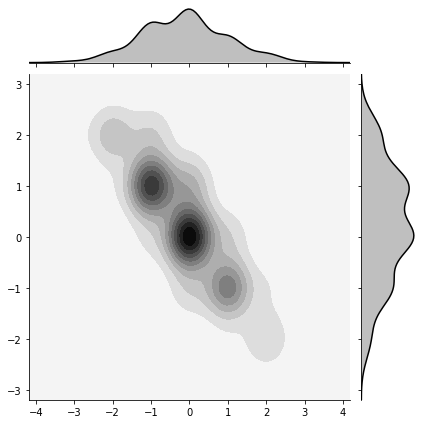

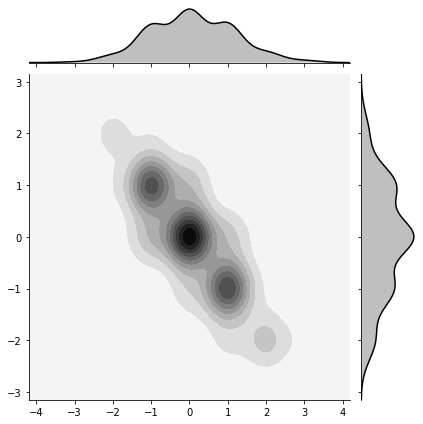

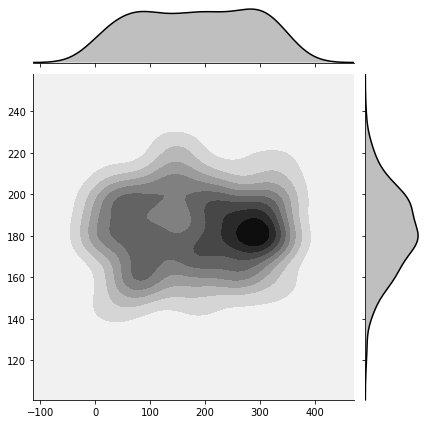

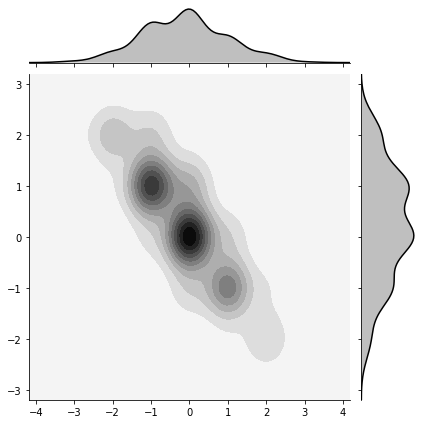

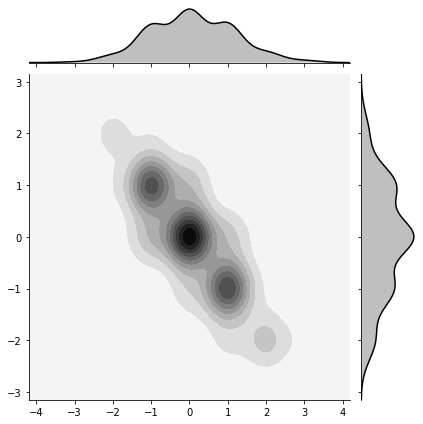

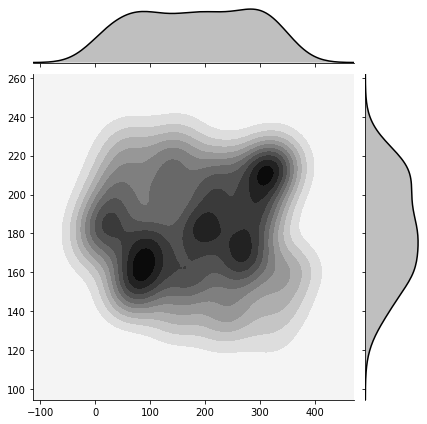

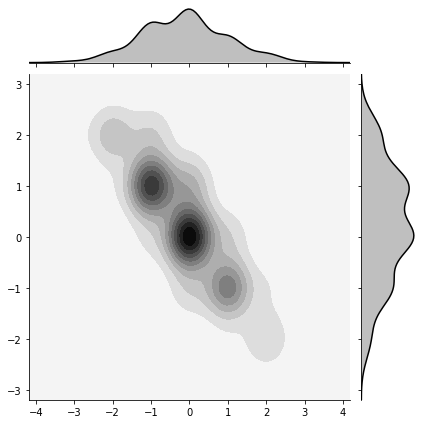

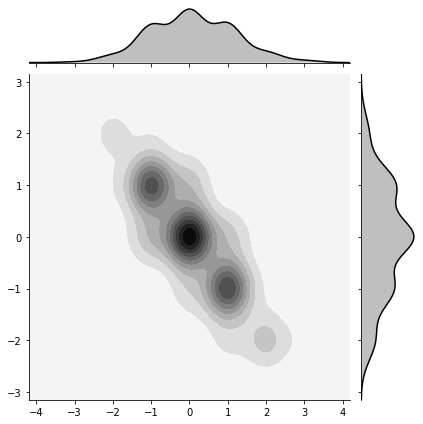

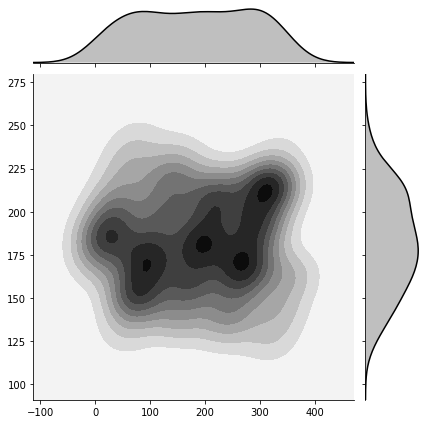

In [ ]:
import seaborn as sns
for c in range(n_A_updates):
    sns.jointplot(x=true_shifts[:small_N,0], y=best_shift_rs[-1,:small_N], kind="kde", color="k");
    sns.jointplot(x=true_shifts[:small_N,1], y=best_shift_cs[-1,:small_N], kind="kde", color="k");
    sns.jointplot(x=true_angles[:small_N], y=best_angles[c,:small_N], kind="kde", color="k");

In [ ]:
import scipy.stats
pr,pc,pa =\
  scipy.stats.pearsonr(true_shifts[:small_N,0],best_shift_rs[-1,:small_N])[0],\
  scipy.stats.pearsonr(true_shifts[:small_N,1],best_shift_cs[-1,:small_N])[0],\
  scipy.stats.pearsonr(true_angles[:small_N],best_angles[-1,:small_N])[0],

In [ ]:
'|%i|%.2f|%.2f|%.2f|%i|%i|%.2f|%.2f/%.2f|'%(nx, scale, lam_k,sigma_shift,shift_span,small_N,deg_step,pr,pc)

'|102|10.00|5.00|1.00|3|200|0.50|-0.88/-0.84|'

# Conclusions
* Rotations
  * searching for rotations does work! from rotationally randomized starting template (unalighed), at least at scale=4, lam_k=1. this is interesting because we need poisson stats here, not gaussian.
* Search over shifts (motion correction)
  * However, searching over shifts is possible, even from a blured out template (blured over all unshifted, but rotation still correct).
  * The low can the dose go?
  
|nx|scale|lam_k|sigma_shift|shift_span|N|deg_step|notes|
|-|-|-|-|-|-|-|-|
|270|5|5|3|12?|100|1|template start from aligned, works in one iteration, stays constant over three iterations, 100% shift prediction accuracy|
|270|5|5|3|12?|100|1|template start from un aligned, works in one iteration, stays constant over three iterations, 97.2/99.9% row/col shift rpearson|
|270|2.50|5|1.5|5|200|1|start from blurry template of just 10 images, looks good after 1 iteration, shift_span only 5, so most of pixels predicted within +- 1 or 2, pr/pc=0.40/0.71|
|270|1|5|3|10|500|1|shifts all at zero, template not improved, still same amount of fuzzyness pr/pc=-0.01/0.12|
|270|2|2|3|12|500|1|after 1 iterations, can see sharp features. 2 iterations a bit better. hard to tell improvement for 3-8 iterations, but good enough. 8 itt pr/pc=0.96/0.99|
|270|4|1|0.50|1|100|1|with rotational search. after three iterations found template.|
|270|2|2|0.5|1|100|1|rotational alignment didn't work. best rotation always zero. interpolation effect?|
|270|3|1|0.50|1|50|1|angular search worked, needed 4 iterations. pr/pc/pa=nan/nan/0.15|
|270|2.50|5.00|0.01|0|300|1|nan/nan/0.02. can't align to rotationally averaged template in 4 iterations, not improving. perhaps noise is too high|
|270|2.50|5.00|0.01|0|300|1|nan/nan/0.40. alignment looks like atomic triangle symbol. started from particles within 20 deg of true angle. (a bit rotationally blurred), did not improve but got worse (a bit)|
|270|3|2|0.01|0|300|1|nan/nan/0.43. rotational alignment needs 4 iterations. big difference between 3 and 4 iterations.|
|270|3|2|0.01|0|300|2|top view (before was side view). nan/nan/0.08. by second iteration looking nice and crisp. pa low because C4 symmetry, so rotations can be io deg off and align well. search to 90 deg did not work well (not sure why). deg step 2 (before 1). |
|270|3|3|0.01|0|300|2|nan/nan/-0.04. starting from rotationally averaged template. can see it is working. did 3 iterations and gets better each time. need to search from 0-360 deg, doesn't work with 0-90 even through C4 symetry|
|270|3|4|0.01|0|300|2|nan/nan/0.16. looking really good by 3-4 iterations|
|270|3|5|0.01|0|300|2.00|nan/nan/0.03, looking good at 4 iterations, and like it could keep improving|
|270|3.00|6.00|0.01|0|300|2.00|nan/nan/0.05. after 7 iterations no visible improvement. too much noise? or need more particles?|
|270|3|5.5|0.01|0|500|2.00|nan/nan/0.05. after 7 iterations very little visible improvement. too much noise? perhaps need several more iterations?|
|270|10.00|10.00|0.01|0|50|2.00|nan/nan/0.04. template improves a bit after first iteration but not quite getting it. some are off by 45 deg|
|102|30.00|10.00|0.01|0|100|2.00|nan/nan/0.04. downsampled to 102 pixels, before zoom 0.9, zero pad 1/4 width (270 pixels). got good alignment by second iteration. enough signal to align first few particles well|
|102|20.00|10.00|0.01|0|100|2.00|converging right away. great by end of 2nd itt|
|102|10.00|10.00|0.01|0|200|2.00|needs 2-3 iterations to converge.|
|102|50|100|0.01|0|200|2.00|did not converge after 3 itt, if aligning to template, gi finding right angles. problem starting from randomized template.|
|102|100|100|0.01|0|100|2.00|finds template in 2-3 iterations. so code is numerically stable at large lambda with gaussian like stats|
|102|75.00|100.00|0.01|0|100|2.00|can tell by eye how should be rotated. but not working at least in 3 iterations.|
|102|75.00|100.00|0.01|0|100|0.50|increased angular sampling and get in three itt. improves a bit in 4th itt, but hard to see further improvement after (checked to 10)|
|102|25.00|100.00|0.01|0|100|0.50|doesn't get template after 5 itt. still essentially at starting template. at this noise level can see orientation of single noisy image faintly by eye, so could go by hand in principle|
|102|50.00|100.00|0.01|0|100|0.50|just coming together by 5th iteration, need 1 or two more (only did to 5). can definitely align single noisy image by eye|
|102|40.00|100.00|0.01|0|200|0.50|didn't align even after 10 itt. can see alignment in single noisy image|
|102|10.00|5.00|0.01|0|200|0.50|pretty good template after 1st iteration, great after 2. not much improvement for 3 (did 3 in total).|
|102|10.00|5.00|1.00|3|200|0.50|pr/pc=-0.88/-0.84. can search for shifts and rotations at the same time (but memory maxes out). by two iterations template is crisp (did three and not much improvement 2-3)|

# Future work
* Apply CTF to template in Fouer space, then return to real space. (instead of undo CTF to observed data).

* Plot
  * best alignments over iteration

* Learn shift spread
$$\sigma_q^2 = N^{-1} \sum_i Z_i^{-1} \int d^2{\bf q}_i \gamma_i |{\bf q}_i|^2$$
  * Where ${\bf q}_i=(q_{i1},q_{i2})$ is the x and y shift of particle $i$.

* Do in Fourier space, if convenient way to get analytical form: 
  * https://math.stackexchange.com/questions/635900/given-a-poisson-noisy-signal-what-is-the-noise-distribution-of-its-fourier-tran
  * https://tspace.library.utoronto.ca/bitstream/1807/16254/1/NQ63594.pdf

# scratch

* Gabor T. Herman. 2012. Fundamentals of Computerized Tomography. Springer London.
  * See discussion of Poisson in photon statistics in Chapter 3 Physical Problems Associated wtih Data Collection in CT, p. 37
  
* https://bmcstructbiol.biomedcentral.com/articles/10.1186/s12900-018-0094-3
  * Mentions Poisson noise, includes two refs
    * Entropy 2015, 17(5), 3461-3478; https://doi.org/10.3390/e17053461
    * http://is.tuebingen.mpg.de/fileadmin/user_upload/files/publications/2011/MIAAB-2011-Joubert.pdf

In [ ]:
# A_rot_ = A_rot.copy()
# Alog = np.log(A_rot_)
# Alog[~np.isfinite(Alog)] = Alog[np.isfinite(Alog)].min()
# Alog.min()
# #np.isfinite(Alog).mean()

In [ ]:
#K = (np.multiply(x.reshape(x.shape+(1,)),Alog) - A_rot).sum(axis=(0,1))
# K = (np.multiply(x.reshape(x.shape+(1,)),Alog)).sum(axis=(0,1))

In [ ]:
# pd.Series(K).plot.hist()

If we scale the largest value to $+11355$, we should be able to compute over angles that have as negative a $\sum_\alpha X_{i \alpha} \ln(A_\alpha) - A_\alpha - K$ as $-11380$ (we can recode the sum as `np.float128` after we compute it. But we see that some other angles are in range and will not give zero.

This is very dependent on the scale of the observed image.

In [ ]:
(K - K.max()+11355).astype(int)

In [ ]:
log_gi = (K - K.max()+11355).astype(np.float128)
gi = np.exp(log_gi)
pd.Series(log_gi).plot()

In [ ]:
gi

# Derivative of $x^x$
* video derivation from [blackpenredpen in 2017](https://youtu.be/l-iLg07zavc)